# Final project Python Notebook
---
- dealer policy: HIT17
- fixed player policy: sticks on 20 or 21, otherwise hit
- policy found by unwiehgted sampling MonteCarlo and off-policy n_step Satsa are both $\varepsilon-greedy$ policies.
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#import pickle

This algorithm runs our target policy for a large amount of episodes.
borrowed from Jeremy's code

In [2]:
class BlackJack_estimate_run(object):

    def __init__(self):
        #self.player_state_value = {}
        self.player_states = []
        self.player_win = 0
        self.player_draw = 0
        self.player_returns={}
        self.player_state_count={}


        # initialise V values | (12-21) x (1-10) x (True, False) 200 in total

        for i in range(12, 22):
            for j in range(1, 11):
                for k in [True, False]:
                    self.player_returns[(i, j, k)] = 0
                    self.player_state_count[(i,j,k)] = 0

    # give card
    # giveCard() function is borrowed from BlackJack base code
    @staticmethod
    def giveCard():
        # 1 stands for ace
        c_list = list(range(1, 11)) + [10, 10, 10]
        return np.random.choice(c_list)

    # dealerPolicy() function is borrowed from BlackJack base code
    def dealerPolicy(self, current_value, usable_ace, is_end):
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return current_value, usable_ace, True
        # HIT17
        if current_value >= 17:
            return current_value, usable_ace, True
        else:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value+11, True, False
                return current_value+1, usable_ace, False
            else:
                return current_value+card, usable_ace, False

    # one can only has 1 usable ace
    # playerPolicy() function is borrowed from BlackJack base code
    def playerPolicy(self, current_value, usable_ace, is_end):
        """_summary_

        Args:
            current_value (_type_): _description_
            usable_ace (_type_): _description_
            is_end (bool): _description_

        Returns:
            state: return the next state
            reward: temporal reward
        """
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return (current_value, usable_ace, True),-1
        # HIT20
        if current_value >= 20:
            return (current_value, usable_ace, True),0
        else:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return (current_value+11, True, False),0
                return (current_value+1, usable_ace, False),0
            else:
                return (current_value+card, usable_ace, False),0


    def reset(self):
        self.player_state_action = []
        self.rewards = []
        self.state = (0, 0, False)  # initial state
        self.end = False

    # modified to implement N-step TD method
    def _giveCredit(self,player_value, dealer_value, is_end):
        # update state value and win count
        if is_end:
            # give reward only to last state
            last_state = self.player_states[-1]
            if player_value > 21:
                if dealer_value > 21:
                    # draw
                    self.player_draw += 1
                    return 0
                else:
                    #self.player_state_value[last_state] -= 1
                    return -1

            else:
                if dealer_value > 21:
                    #self.player_state_value[last_state] += 1
                    self.player_win += 1
                    return 1
                else:
                    if player_value < dealer_value:
                        #self.player_state_value[last_state] -= 1
                        return -1
                    elif player_value > dealer_value:
                        #self.player_state_value[last_state] += 1
                        self.player_win += 1
                        return 1
                    else:
                        # draw
                        self.player_draw += 1
                        return 0




    def play(self, rounds=1000):
        for i in np.arange(rounds):
            #self.reset()
            #if i % 10000 == 0:
            #    print("round", i)
            # hit 2 cards each
            dealer_value, player_value = 0, 0
            show_card = 0

            # give dealer 2 cards and show 1
            dealer_value += self.giveCard()
            show_card = dealer_value
            dealer_value += self.giveCard()

            # player's turn
            # always hit if less than 12
            usable_ace, is_end = False, False

            lis_states = []
            while True:
                state,reward = self.playerPolicy(player_value, usable_ace, is_end)
                player_value, usable_ace, is_end = state

                # when value goes higher than 12, record states
                if (player_value >= 12) and (player_value <= 21):
                    lis_states.append((player_value, show_card, usable_ace))

                if is_end:
                    break
            self.player_states.append(lis_states)
            # print("player card sum", player_value)

            # dealer's turn
            usable_ace, is_end = False, False
            while not is_end:
                dealer_value, usable_ace, is_end = self.dealerPolicy(dealer_value, usable_ace, is_end)
            # print("dealer card sum", dealer_value)

            # judge winner
            # set intermediate state to 0
            #for s in self.player_states:
            #    self.player_state_value[s] = 0 if self.player_state_value.get(s) is None else self.player_state_value.get(s)

            final_reward = self._giveCredit(player_value,dealer_value,is_end)

            #updating returns

            for state in lis_states:
                self.player_state_count[state] = self.player_state_count[state]+1
                N=self.player_state_count[state]
                cur_val = self.player_returns[state]
                self.player_returns[state] = cur_val+(1/N)*(final_reward-cur_val)











In [3]:
np.random.seed(200)
b_est = BlackJack_estimate_run()
b_est.play(1000000)

In [4]:
b_est.player_returns

{(12, 1, True): -0.09032258064516123,
 (12, 1, False): -0.3543554427932822,
 (12, 2, True): -0.059426229508196725,
 (12, 2, False): -0.26919362626750415,
 (12, 3, True): -0.08695652173913042,
 (12, 3, False): -0.2616314199395765,
 (12, 4, True): -0.004618937644341811,
 (12, 4, False): -0.23116295679085913,
 (12, 5, True): 0.0854166666666667,
 (12, 5, False): -0.2299439161180207,
 (12, 6, True): 0.06843267108167769,
 (12, 6, False): -0.2258064516129033,
 (12, 7, True): -0.021691973969631226,
 (12, 7, False): -0.3085995085995071,
 (12, 8, True): -0.09482758620689662,
 (12, 8, False): -0.3252586731588556,
 (12, 9, True): -0.022587268993839844,
 (12, 9, False): -0.3302207130730036,
 (12, 10, True): -0.11771117166212532,
 (12, 10, False): -0.3802193806435985,
 (13, 1, True): -0.19499478623566194,
 (13, 1, False): -0.3829279923700534,
 (13, 2, True): -0.06659267480577141,
 (13, 2, False): -0.28994845360824645,
 (13, 3, True): -0.07395143487858723,
 (13, 3, False): -0.2936489336770564,
 (13, 

In [5]:
basline_val = b_est.player_returns[(13,1,True)]

In [6]:
basline_val

-0.19499478623566194

Now we check our winning rate by our fixed policy as in textbook, section 5.1, page 93.

In [7]:
print("fixed policy winning rate: ", b_est.player_win/1000000)
print("fixed policy draw rate: ", b_est.player_draw/1000000)

fixed policy winning rate:  0.306089
fixed policy draw rate:  0.24448


## Section: n_Step off policy Sarsa

This is our implemented n_Step off policy Sarsa evaluation algorithm. Mostly, the class below is borrowed from online article "Reinforcement Learning — Solving Blackjack" by Jeremy Zhang.  
Except the part that we create our own list of rewards and the final block of the code in this class "BlackJack_N_step_Sarsa_eval" that updates state value by N_step Sarsa method as in page 149 of textbook, "Off policy n-step Sarsa estimating Q $\approx$ $q*$" or $q_\pi$.  


In [8]:
class BlackJack_N_step_Sarsa_eval(object):

    def __init__(self):
        #self.player_state_value = {}
        self.player_states = []
        self.player_win = 0
        self.player_draw = 0
        self.rewards = []
        self.lis_rewards=[]
        self.lr = 0.1
        self.max_T = []

        self.player_V_Values={}
        self.player_final_rewards = []
        self.chosen_state_value = []


        # initialise V values | (12-21) x (1-10) x (True, False) 200 in total

        for i in range(12, 22):
            for j in range(1, 11):
                for k in [True, False]:
                    self.player_V_Values[(i, j, k)] = 0

    # give card
    # giveCard() function is borrowed from BlackJack base code
    @staticmethod
    def giveCard():
        # 1 stands for ace
        c_list = list(range(1, 11)) + [10, 10, 10]
        return np.random.choice(c_list)

    # dealerPolicy() function is borrowed from BlackJack base code
    def dealerPolicy(self, current_value, usable_ace, is_end):
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return current_value, usable_ace, True
        # HIT17
        if current_value >= 17:
            return current_value, usable_ace, True
        else:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value+11, True, False
                return current_value+1, usable_ace, False
            else:
                return current_value+card, usable_ace, False

    # one can only has 1 usable ace
    # playerPolicy() function is borrowed from BlackJack base code
    def playerPolicy(self, current_value, usable_ace, is_end):
        """_summary_

        Args:
            current_value (_type_): _description_
            usable_ace (_type_): _description_
            is_end (bool): _description_

        Returns:
            state: return the next state
            reward: temporal reward
        """
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return (current_value, usable_ace, True),-1
        # HIT20
        if current_value >= 20:
            return (current_value, usable_ace, True),0
        else:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return (current_value+11, True, False),0
                return (current_value+1, usable_ace, False),0
            else:
                return (current_value+card, usable_ace, False),0


    def reset(self):
        self.player_state_action = []
        self.rewards = []
        self.state = (0, 0, False)  # initial state
        self.end = False

    # modified to implement N-step TD method
    def _giveCredit(self,player_value, dealer_value, is_end):
        # update state value and win count
        if is_end:
            # give reward only to last state
            last_state = self.player_states[-1]
            if player_value > 21:
                if dealer_value > 21:
                    # draw
                    self.player_draw += 1
                    self.player_final_rewards.append(0)
                else:
                    #self.player_state_value[last_state] -= 1
                    self.player_final_rewards.append(-1)
            else:
                if dealer_value > 21:
                    #self.player_state_value[last_state] += 1
                    self.player_win += 1
                    self.player_final_rewards.append(1)
                else:
                    if player_value < dealer_value:
                        #self.player_state_value[last_state] -= 1
                        self.player_final_rewards.append(-1)
                    elif player_value > dealer_value:
                        #self.player_state_value[last_state] += 1
                        self.player_win += 1
                        self.player_final_rewards.append(1)
                    else:
                        # draw
                        self.player_draw += 1
                        self.player_final_rewards.append(0)




    def play(self, rounds=1000,n=3,chosen_state=(13,1,True)):
        for i in np.arange(rounds):
            #self.reset()
            #if i % 10000 == 0:
            #    print("round", i)
            # hit 2 cards each
            dealer_value, player_value = 0, 0
            show_card = 0

            # give dealer 2 cards and show 1
            dealer_value += self.giveCard()
            show_card = dealer_value
            dealer_value += self.giveCard()

            # player's turn
            # always hit if less than 12
            usable_ace, is_end = False, False

            lis_states = []
            while True:
                state,reward = self.playerPolicy(player_value, usable_ace, is_end)
                player_value, usable_ace, is_end = state

                # when value goes higher than 12, record states
                if (player_value >= 12) and (player_value <= 21):
                    lis_states.append((player_value, show_card, usable_ace))
                    self.rewards.append(reward)

                if is_end:
                    break
            self.player_states.append(lis_states)
            # print("player card sum", player_value)

            # dealer's turn
            usable_ace, is_end = False, False
            while not is_end:
                dealer_value, usable_ace, is_end = self.dealerPolicy(dealer_value, usable_ace, is_end)
            # print("dealer card sum", dealer_value)

            # judge winner
            # set intermediate state to 0
            #for s in self.player_states:
            #    self.player_state_value[s] = 0 if self.player_state_value.get(s) is None else self.player_state_value.get(s)

            self._giveCredit(player_value,dealer_value,is_end)

            #creating list of rewards
            rewards_here = list(np.zeros(len(self.player_states[i])-1))+[self.player_final_rewards[i]]
            #following code borrowed from my own solution in programming assignment 2
            #off policy n_step sarsa algorithm
            #help from class txt book, page 144, n step TD method estimating V approximately equivalent to v_pi
            t=0
            T=len(self.player_states[i])
            tau=0-n+1
            for t in range(0,T+n-1):
                tau=t-n+1
                if tau>=0:
                    upper = np.min([tau+n,T])
                    G=0
                    for ind in range(tau+1,upper+1):
                        G=G+rewards_here[ind-1]
                    if tau + n < T:
                        s_tau_n = self.player_states[i][tau + n]
                        G += self.player_V_Values[s_tau_n]
                    # Update the value for the state at time tau
                    state_to_update = self.player_states[i][tau]

                    #importance sampling ratio in N_step TD
                    rho=1
                    for indx in np.arange(tau+1,upper):
                        #estimate by random policy, and for our already chosen action, probability is always 1
                        rho=rho*2

                    # Update value function value V(s_tau)
                    cur_val = self.player_V_Values[state_to_update]
                    self.player_V_Values[state_to_update]=cur_val+self.lr * rho * (G - cur_val)
            self.chosen_state_value.append(self.player_V_Values[chosen_state])











In [9]:
state_eval = 0
chosen_state_val_lis = []
# random seed to ensure 100 different estimations for state value (13,1,True)
for ind in range(100):
    np.random.seed(ind)
    print(" seed: ",ind)
    b_N_step_eval = BlackJack_N_step_Sarsa_eval()
    b_N_step_eval.play(rounds=10000)
    #print(b_N_step_eval.player_V_Values[(13,1,True)])
    state_eval +=b_N_step_eval.player_V_Values[(13,1,True)]
    chosen_state_val_lis.append(b_N_step_eval.chosen_state_value)


 seed:  0
 seed:  1
 seed:  2
 seed:  3
 seed:  4
 seed:  5
 seed:  6
 seed:  7
 seed:  8
 seed:  9
 seed:  10
 seed:  11
 seed:  12
 seed:  13
 seed:  14
 seed:  15
 seed:  16
 seed:  17
 seed:  18
 seed:  19
 seed:  20
 seed:  21
 seed:  22
 seed:  23
 seed:  24
 seed:  25
 seed:  26
 seed:  27
 seed:  28
 seed:  29
 seed:  30
 seed:  31
 seed:  32
 seed:  33
 seed:  34
 seed:  35
 seed:  36
 seed:  37
 seed:  38
 seed:  39
 seed:  40
 seed:  41
 seed:  42
 seed:  43
 seed:  44
 seed:  45
 seed:  46
 seed:  47
 seed:  48
 seed:  49
 seed:  50
 seed:  51
 seed:  52
 seed:  53
 seed:  54
 seed:  55
 seed:  56
 seed:  57
 seed:  58
 seed:  59
 seed:  60
 seed:  61
 seed:  62
 seed:  63
 seed:  64
 seed:  65
 seed:  66
 seed:  67
 seed:  68
 seed:  69
 seed:  70
 seed:  71
 seed:  72
 seed:  73
 seed:  74
 seed:  75
 seed:  76
 seed:  77
 seed:  78
 seed:  79
 seed:  80
 seed:  81
 seed:  82
 seed:  83
 seed:  84
 seed:  85
 seed:  86
 seed:  87
 seed:  88
 seed:  89
 seed:  90
 seed:  9

We check our off_policy n-step Sarsa method's performance on estimating state value for state player sum is 13, player has an usable ace and dealer shows an ace.

In [10]:
state_eval/100

0.04848063001942913

In [11]:
basline_val

-0.19499478623566194

This is rather far from baseline value for state (13,1,True). We will have a further check of our off_policy n-step Sarsa method's performance on estimating state value for state player sum is 13, player has an usable ace and dealer shows an ace through computing an mean square error of our **off_policy n-step Sarsa** method's estimation of state value for state (13,1,True) throughout the 10000 iterations, and averaged over all 100 runs.

Computing mean square error averaging our off policy n_step Sarsa method over 100 runs for each of episode.

In [12]:
MSE_col_n_Step_Sarsa = []

for iter in range(0,10000):
    MSE = 0
    N=0
    for j in range(0,100):
        N=N+1
        mse_cur = (chosen_state_val_lis[j][iter]-basline_val)**2
        MSE = MSE+(1/N)*(mse_cur-MSE)
    MSE_col_n_Step_Sarsa.append(MSE)

In [13]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'episodes')

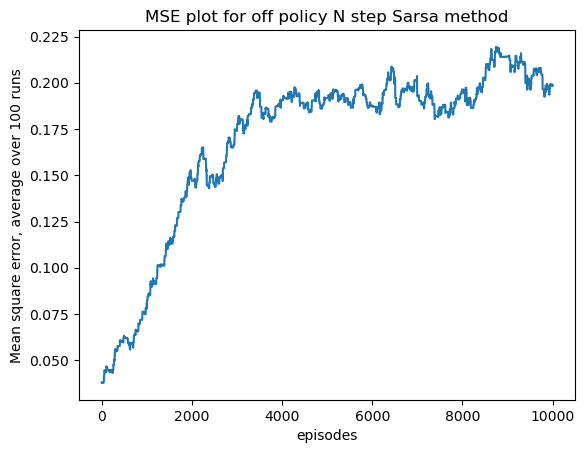

In [14]:
plt.plot(MSE_col_n_Step_Sarsa)
plt.title("MSE plot for off policy N step Sarsa method")
plt.ylabel("Mean square error, average over 100 runs")
plt.xlabel("episodes")

It seems that in our off-policy n_step SARSA method, since the $\rho(t:h)$ for each return G is too large, if there's any error due to randomness in our computating process, this error might be enlarged and propagate. Thus our algorithm fails to converge.

Now we try to figure out a epsilon-greedy policy for playing blackjack by using our n_Step Sarsa control METHOD.

This is our implemented n_Step off policy Sarsa control algorithm findind an optimal policy playing Blakcjack. Mostly, the class below is borrowed from online article "Reinforcement Learning — Solving Blackjack" by Jeremy Zhang.  
Except the part that we create our own list of rewards and the final block of the code in this class "BlackJack_N_step_Sarsa_eval" that updates state value by N_step Sarsa method as in page 149 of textbook, "Off policy n-step Sarsa estimating Q $\approx$ $q*$" or $q_\pi$.  


In [15]:
class BlackJack_n_Step_Sarsa_control(object):
    # init function borrowed from website article "Reinforcement Learning — Solving Blackjack"
    # by Jeremy Zhang in towardsdatascience.com
    # initizliation function of blackjack object
    def __init__(self,epsilon=0.1):
        #self.player_state_value = {}
        self.epsilon=epsilon
        self.lr = 0.1
        self.player_Q_Values={}
        self.policy = {} #initialize a epsilon-soft policy
        self.player_states = []
        self.player_final_rewards=[]
        self.player_draw = 0
        self.player_win=0


        # initialise V values | (12-21) x (1-10) x (True, False) x (1,0) 400 in total

        for i in range(12, 22):
            for j in range(1, 11):
                for k in [True, False]:
                    self.player_Q_Values[(i, j, k)] = {}
                    self.player_Q_Values[(i,j,k)][1]=0
                    self.player_Q_Values[(i,j,k)][0]=0
                    self.policy[(i,j,k)]=[0.5,0.5]
    # give card
    # give card function borrowed from website article "Reinforcement Learning — Solving Blackjack"
    # by Jeremy Zhang in towardsdatascience.com
    @staticmethod
    def giveCard():
        # 1 stands for ace
        c_list = list(range(1, 11)) + [10, 10, 10]
        return np.random.choice(c_list)
    # dealer policy and player policy function borrowed from website article
    # "Reinforcement Learning — Solving Blackjack"
    # by Jeremy Zhang in towardsdatascience.com
    def dealerPolicy(self, current_value, usable_ace, is_end):
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return current_value, usable_ace, True
        # HIT17
        if current_value >= 17:
            return current_value, usable_ace, True
        else:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value+11, True, False
                return current_value+1, usable_ace, False
            else:
                return current_value+card, usable_ace, False

    # one can only has 1 usable ace
    def playerPolicy(self, current_value, show_card, usable_ace, is_end):
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return current_value, usable_ace, None, True

        #always hit when total sum smaller than 12
        if current_value < 12:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value+11, True, 1, False
                return current_value+1, usable_ace, 1, False
            else:
                return current_value+card, usable_ace, 1, False
        # epsilon-soft policy here performed
        action = np.random.choice([0,1],p=self.policy[(current_value,show_card,usable_ace)])
        if action==0:
            return current_value, usable_ace, 0, True
        else:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value+11, True, 1, False
                return current_value+1, usable_ace, 1, False
            else:
                return current_value+card, usable_ace, 1, False


    # give credit function borrowed from website article
    # "Reinforcement Learning — Solving Blackjack"
    # by Jeremy Zhang in towardsdatascience.com
    def _giveCredit(self, player_value, dealer_value, cur_traj, is_end=True):
        if is_end:
            if player_value > 21:
                if dealer_value > 21:
                    # draw
                    self.player_draw += 1
                    self.player_final_rewards.append(0)
                else:
                    self.player_final_rewards.append(-1)
            else:
                if dealer_value > 21:
                    self.player_final_rewards.append(1)
                    self.player_win += 1
                else:
                    if player_value < dealer_value:
                        self.player_final_rewards.append(-1)
                    elif player_value > dealer_value:
                        self.player_final_rewards.append(1)
                        self.player_win += 1
                    else:
                        # draw
                        self.player_draw += 1
                        self.player_final_rewards.append(0)
                        
                        
    def play(self, rounds=1000,n=3):
        for i in range(rounds):
            if i % 10000 == 0:
                print("round", i)
            # hit 2 cards each
            dealer_value, player_value = 0, 0
            show_card = 0

            # give dealer 2 cards and show 1
            dealer_value += self.giveCard()
            show_card = dealer_value
            dealer_value += self.giveCard()

            #list of states for players
            lis_player_states = []

            #col of actions
            col_actions = {}
            # player's turn
            # always hit if less than 12
            usable_ace, is_end = False, False
            while True:

                player_value, usable_ace, action, is_end = self.playerPolicy(player_value, show_card, usable_ace, is_end)
                col_actions[(player_value, show_card, usable_ace)]=action

                # when value goes higher than 12, record states
                if (player_value >= 12) and (player_value <= 21):
                    lis_player_states.append((player_value, show_card, usable_ace))

                    #self.player_state_count[(player_value, show_card, usable_ace)]+=1

                if is_end:
                    break

            self.player_states.append(lis_player_states)
            # print("player card sum", player_value)

            # dealer's turn
            usable_ace, is_end = False, False
            while not is_end:
                dealer_value, usable_ace, is_end = self.dealerPolicy(dealer_value, usable_ace, is_end)

            # judge winner
            # set intermediate state to 0
            #for s in self.player_states:
            #    self.player_state_value[s] = 0 if self.player_state_value.get(s) is None else self.player_state_value.get(s)

            self._giveCredit(player_value, dealer_value,self.player_states[-1])

            #creating list of rewards
            rewards_here = list(np.zeros(len(self.player_states[i])-1))+[self.player_final_rewards[i]]

            #following code borrowed from my own solution in programming assignment 2
            #off policy n_step sarsa algorithm
            #help from class txt book, page 144, n step TD method estimating V approximately equivalent to v_pi
            t=0
            T=len(self.player_states[i])
            tau=0-n+1
            for t in range(0,T+n-1):
                tau=t-n+1
                if tau>=0:
                    upper = np.min([tau+n,T])
                    G=0
                    for ind in range(tau+1,upper+1):
                        G=G+rewards_here[ind-1]
                    if tau + n < T:
                        s_tau_n = self.player_states[i][tau + n]
                        a_tau_n = col_actions[s_tau_n]
                        G += self.player_Q_Values[s_tau_n][a_tau_n]
                    # Update the value for the state at time tau
                    s_tau = self.player_states[i][tau]
                    a_tau= col_actions[s_tau]


                    #importance sampling ratio in N_step TD
                    rho=1
                    for indx in np.arange(tau+1,upper):
                        #estimate by random policy, and for our already chosen action, probability is always 1
                        s_here=self.player_states[i][indx]
                        a_here=col_actions[s_here]
                        ratio = self.policy[s_here][a_here] / 0.5
                        rho=rho*ratio

                    # Update value function value V(s_tau)
                    cur_val = self.player_Q_Values[s_tau][a_tau]
                    self.player_Q_Values[s_tau][a_tau]=cur_val+self.lr * rho * (G - cur_val)
                    a_star = np.argmax([self.player_Q_Values[s_tau][0],self.player_Q_Values[s_tau][1]])

                    for a in range(2):
                        if a==a_star:
                            self.policy[s_tau][a]=1-self.epsilon+self.epsilon/2
                        else:
                            self.policy[s_tau][a]=self.epsilon/2





We develop an averaged policy for playing Blakcjack through using 5 seeds, and averaging the policy probabilities generated by the 5 seeds, 300 to 304. Potentially improve the generality of the policy we found.

In [16]:
policies = []
for i in range(300,305):
    np.random.seed(i)
    b_N_step_Sarsa_control = BlackJack_n_Step_Sarsa_control()
    b_N_step_Sarsa_control.play(rounds=10000)
    policies.append(b_N_step_Sarsa_control.policy)

round 0
round 0
round 0
round 0
round 0


In [17]:
final_policy_n_step_Sarsa = {}
for i in range(12, 22):
    for j in range(1, 11):
        for k in [True, False]:
            final_policy_n_step_Sarsa[(i,j,k)]=[0,0]
N=0
for ind in range(0,5):
    N=N+1
    for i in range(12, 22):
        for j in range(1, 11):
            for k in [True, False]:
                update_prob=policies[ind][(i,j,k)]
                cur_prob=final_policy_n_step_Sarsa[(i,j,k)]

                final_policy_n_step_Sarsa[(i,j,k)][0]=cur_prob[0]+(1/N)*(update_prob[0]-cur_prob[0])
                final_policy_n_step_Sarsa[(i,j,k)][1]=cur_prob[1]+(1/N)*(update_prob[1]-cur_prob[1])

In [18]:
final_policy_n_step_Sarsa

{(12, 1, True): [0.23, 0.7700000000000001],
 (12, 1, False): [0.05, 0.9500000000000001],
 (12, 2, True): [0.41, 0.5900000000000001],
 (12, 2, False): [0.22999999999999998, 0.7700000000000001],
 (12, 3, True): [0.23, 0.7700000000000001],
 (12, 3, False): [0.05, 0.9500000000000001],
 (12, 4, True): [0.41, 0.5900000000000001],
 (12, 4, False): [0.41, 0.5900000000000001],
 (12, 5, True): [0.41, 0.5900000000000001],
 (12, 5, False): [0.22999999999999998, 0.7700000000000001],
 (12, 6, True): [0.7700000000000001, 0.22999999999999998],
 (12, 6, False): [0.41, 0.5900000000000001],
 (12, 7, True): [0.23000000000000004, 0.77],
 (12, 7, False): [0.05, 0.9500000000000001],
 (12, 8, True): [0.41, 0.5900000000000001],
 (12, 8, False): [0.05, 0.9500000000000001],
 (12, 9, True): [0.41, 0.5900000000000001],
 (12, 9, False): [0.05, 0.9500000000000001],
 (12, 10, True): [0.22999999999999998, 0.7700000000000001],
 (12, 10, False): [0.05, 0.9500000000000001],
 (13, 1, True): [0.23, 0.7700000000000001],
 (1

We defined the corresponding blackjack running process with our final policy as follow

This is our implemented BlackJack rerun algorithm testing if our generated optimal policy beats the dealer or has some improvement over our original run. Mostly, the class below is borrowed from online article "Reinforcement Learning — Solving Blackjack" by Jeremy Zhang.  


In [19]:
class BlackJack_estimate_rerun(object):

    def __init__(self,policy_prob):
        #self.player_state_value = {}
        self.player_states = []
        self.player_win = 0
        self.player_draw = 0
        self.player_lose=0
        self.policy_prob=policy_prob

        # initialise V values | (12-21) x (1-10) x (True, False) 200 in total



    # give card
    # giveCard() function is borrowed from BlackJack base code
    @staticmethod
    def giveCard():
        # 1 stands for ace
        c_list = list(range(1, 11)) + [10, 10, 10]
        return np.random.choice(c_list)

    # dealerPolicy() function is borrowed from BlackJack base code
    def dealerPolicy(self, current_value, usable_ace, is_end):
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return current_value, usable_ace, True
        # HIT17
        if current_value >= 17:
            return current_value, usable_ace, True
        else:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value+11, True, False
                return current_value+1, usable_ace, False
            else:
                return current_value+card, usable_ace, False

    # one can only has 1 usable ace
    # playerPolicy() function is borrowed from BlackJack base code
    # one can only has 1 usable ace
    def playerPolicy(self, current_value, show_card, usable_ace, is_end):
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return current_value, usable_ace, True

        #always hit when total sum smaller than 12
        if current_value < 12:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value+11, True, False
                return current_value+1, usable_ace, False
            else:
                return current_value+card, usable_ace, False
        # epsilon-soft policy here performed
        action = np.random.choice([0,1],p=self.policy_prob[(current_value,show_card,usable_ace)])
        if action==0:
            return current_value, usable_ace, True
        else:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value+11, True, False
                return current_value+1, usable_ace, False
            else:
                return current_value+card, usable_ace, False


    def reset(self):
        self.player_state_action = []
        self.rewards = []
        self.state = (0, 0, False)  # initial state
        self.end = False

    # modified to implement N-step TD method
    def _giveCredit(self,player_value, dealer_value, is_end):
        # update state value and win count
        if is_end:
            # give reward only to last state
            last_state = self.player_states[-1]
            if player_value > 21:
                if dealer_value > 21:
                    # draw
                    self.player_draw += 1
                else:
                    self.player_lose +=1

            else:
                if dealer_value > 21:
                    self.player_win += 1

                else:
                    if player_value < dealer_value:
                        self.player_lose+=1
                    elif player_value > dealer_value:
                        self.player_win += 1
                    else:
                        # draw
                        self.player_draw += 1




    def play(self, rounds=1000):
        for i in np.arange(rounds):
            #self.reset()
            #if i % 10000 == 0:
            #    print("round", i)
            # hit 2 cards each
            dealer_value, player_value = 0, 0
            show_card = 0

            # give dealer 2 cards and show 1
            dealer_value += self.giveCard()
            show_card = dealer_value
            dealer_value += self.giveCard()

            # player's turn
            # always hit if less than 12
            usable_ace, is_end = False, False

            lis_states = []
            while True:
                player_value, usable_ace, is_end = self.playerPolicy(player_value, show_card, usable_ace, is_end)

                # when value goes higher than 12, record states
                if (player_value >= 12) and (player_value <= 21):
                    lis_states.append((player_value, show_card, usable_ace))

                if is_end:
                    break
            self.player_states.append(lis_states)
            # print("player card sum", player_value)

            # dealer's turn
            usable_ace, is_end = False, False
            while not is_end:
                dealer_value, usable_ace, is_end = self.dealerPolicy(dealer_value, usable_ace, is_end)
            # print("dealer card sum", dealer_value)

            # judge winner

            self._giveCredit(player_value,dealer_value,is_end)




In [20]:
np.random.seed(500)
n_Step_Sarsa_rerun=BlackJack_estimate_rerun(policy_prob=final_policy_n_step_Sarsa)
n_Step_Sarsa_rerun.play(10000)

Now we finally check our winning rate based on policies chosen by off policy N_Step Sarsa method

In [21]:
n_Step_Sarsa_rerun.player_win,n_Step_Sarsa_rerun.player_draw,n_Step_Sarsa_rerun.player_lose

(3737, 1966, 4297)

In [22]:
print("n Step Sarsa winning rate:",n_Step_Sarsa_rerun.player_win/10000)

n Step Sarsa winning rate: 0.3737


Unfortunately we did not beat the dealer, however, we managed to have an improved winning rate from the original 1000000 runs with our fit policy.  
The improvement is from 30.6% to 37.4%.

## Section: n_Step TD

This is our implemented n_Step TD evaluation algorithm. Mostly, the class below is borrowed from online article "Reinforcement Learning — Solving Blackjack" by Jeremy Zhang.
Except the part that we reare our own list of rewards and the final block of the code in this class "BlackJack_N_step_TD_eval" that updates state value by N_step TD method as in page 144 ot textbook, "n-step TD for estimating $V\approx v_\pi$".  

In [23]:
class BlackJack_N_step_TD_eval(object):

    def __init__(self):
        #self.player_state_value = {}
        self.player_states = []
        self.player_win = 0
        self.player_draw = 0
        self.rewards = []
        self.lis_rewards=[]
        self.lr = 0.1
        self.max_T = []

        self.player_V_Values={}
        self.player_final_rewards = []
        self.chosen_state_value = []


        # initialise V values | (12-21) x (1-10) x (True, False) 200 in total

        for i in range(12, 22):
            for j in range(1, 11):
                for k in [True, False]:
                    self.player_V_Values[(i, j, k)] = 0

    # give card
    # giveCard() function is borrowed from BlackJack base code
    @staticmethod
    def giveCard():
        # 1 stands for ace
        c_list = list(range(1, 11)) + [10, 10, 10]
        return np.random.choice(c_list)

    # dealerPolicy() function is borrowed from BlackJack base code
    def dealerPolicy(self, current_value, usable_ace, is_end):
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return current_value, usable_ace, True
        # HIT17
        if current_value >= 17:
            return current_value, usable_ace, True
        else:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value+11, True, False
                return current_value+1, usable_ace, False
            else:
                return current_value+card, usable_ace, False

    # one can only has 1 usable ace
    # playerPolicy() function is borrowed from BlackJack base code
    def playerPolicy(self, current_value, usable_ace, is_end):
        """_summary_

        Args:
            current_value (_type_): _description_
            usable_ace (_type_): _description_
            is_end (bool): _description_

        Returns:
            state: return the next state
            reward: temporal reward
        """
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return (current_value, usable_ace, True),-1
        # HIT20
        if current_value >= 20:
            return (current_value, usable_ace, True),0
        else:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return (current_value+11, True, False),0
                return (current_value+1, usable_ace, False),0
            else:
                return (current_value+card, usable_ace, False),0


    def reset(self):
        self.player_state_action = []
        self.rewards = []
        self.state = (0, 0, False)  # initial state
        self.end = False

    # modified to implement N-step TD method
    def _giveCredit(self,player_value, dealer_value, is_end):
        # update state value and win count
        if is_end:
            # give reward only to last state
            last_state = self.player_states[-1]
            if player_value > 21:
                if dealer_value > 21:
                    # draw
                    self.player_draw += 1
                    self.player_final_rewards.append(0)
                else:
                    #self.player_state_value[last_state] -= 1
                    self.player_final_rewards.append(-1)
            else:
                if dealer_value > 21:
                    #self.player_state_value[last_state] += 1
                    self.player_win += 1
                    self.player_final_rewards.append(1)
                else:
                    if player_value < dealer_value:
                        #self.player_state_value[last_state] -= 1
                        self.player_final_rewards.append(-1)
                    elif player_value > dealer_value:
                        #self.player_state_value[last_state] += 1
                        self.player_win += 1
                        self.player_final_rewards.append(1)
                    else:
                        # draw
                        self.player_draw += 1
                        self.player_final_rewards.append(0)




    def play(self, rounds=1000,n=3,chosen_state=(13,1,True)):
        for i in np.arange(rounds):
            #self.reset()
            #if i % 10000 == 0:
            #    print("round", i)
            # hit 2 cards each
            dealer_value, player_value = 0, 0
            show_card = 0

            # give dealer 2 cards and show 1
            dealer_value += self.giveCard()
            show_card = dealer_value
            dealer_value += self.giveCard()

            # player's turn
            # always hit if less than 12
            usable_ace, is_end = False, False

            lis_states = []
            while True:
                state,reward = self.playerPolicy(player_value, usable_ace, is_end)
                player_value, usable_ace, is_end = state

                # when value goes higher than 12, record states
                if (player_value >= 12) and (player_value <= 21):
                    lis_states.append((player_value, show_card, usable_ace))
                    self.rewards.append(reward)

                if is_end:
                    break
            self.player_states.append(lis_states)
            # print("player card sum", player_value)

            # dealer's turn
            usable_ace, is_end = False, False
            while not is_end:
                dealer_value, usable_ace, is_end = self.dealerPolicy(dealer_value, usable_ace, is_end)
            # print("dealer card sum", dealer_value)

            # judge winner
            # set intermediate state to 0
            #for s in self.player_states:
            #    self.player_state_value[s] = 0 if self.player_state_value.get(s) is None else self.player_state_value.get(s)

            self._giveCredit(player_value,dealer_value,is_end)

            #creating list of rewards
            rewards_here = list(np.zeros(len(self.player_states[i])-1))+[self.player_final_rewards[i]]
            #following code borrowed from my own solution in programming assignment 2
            #off policy n_step sarsa algorithm
            #help from class txt book, page 144, n step TD method estimating V approximately equivalent to v_pi
            t=0
            T=len(self.player_states[i])
            tau=0-n+1
            for t in range(0,T+n-1):
                tau=t-n+1
                if tau>=0:
                    upper = np.min([tau+n,T])
                    G=0
                    for ind in range(tau+1,upper+1):
                        G=G+rewards_here[ind-1]
                    if tau + n < T:
                        s_tau_n = self.player_states[i][tau + n]
                        G += self.player_V_Values[s_tau_n]
                    # Update the value for the state at time tau
                    state_to_update = self.player_states[i][tau]


                    # Update value function value V(s_tau)
                    cur_val = self.player_V_Values[state_to_update]
                    self.player_V_Values[state_to_update]=cur_val+self.lr * (G - cur_val)
            self.chosen_state_value.append(self.player_V_Values[chosen_state])











In [24]:
state_eval = 0
chosen_state_val_lis01 = []
for ind in range(100):
    np.random.seed(ind)
    print(" seed: ",ind)
    b_N_TD_eval = BlackJack_N_step_TD_eval()
    b_N_TD_eval.play(rounds=10000)
    #print(b_N_step_eval.player_V_Values[(13,1,True)])
    state_eval +=b_N_TD_eval.player_V_Values[(13,1,True)]
    chosen_state_val_lis01.append(b_N_TD_eval.chosen_state_value)


 seed:  0
 seed:  1
 seed:  2
 seed:  3
 seed:  4
 seed:  5
 seed:  6
 seed:  7
 seed:  8
 seed:  9
 seed:  10
 seed:  11
 seed:  12
 seed:  13
 seed:  14
 seed:  15
 seed:  16
 seed:  17
 seed:  18
 seed:  19
 seed:  20
 seed:  21
 seed:  22
 seed:  23
 seed:  24
 seed:  25
 seed:  26
 seed:  27
 seed:  28
 seed:  29
 seed:  30
 seed:  31
 seed:  32
 seed:  33
 seed:  34
 seed:  35
 seed:  36
 seed:  37
 seed:  38
 seed:  39
 seed:  40
 seed:  41
 seed:  42
 seed:  43
 seed:  44
 seed:  45
 seed:  46
 seed:  47
 seed:  48
 seed:  49
 seed:  50
 seed:  51
 seed:  52
 seed:  53
 seed:  54
 seed:  55
 seed:  56
 seed:  57
 seed:  58
 seed:  59
 seed:  60
 seed:  61
 seed:  62
 seed:  63
 seed:  64
 seed:  65
 seed:  66
 seed:  67
 seed:  68
 seed:  69
 seed:  70
 seed:  71
 seed:  72
 seed:  73
 seed:  74
 seed:  75
 seed:  76
 seed:  77
 seed:  78
 seed:  79
 seed:  80
 seed:  81
 seed:  82
 seed:  83
 seed:  84
 seed:  85
 seed:  86
 seed:  87
 seed:  88
 seed:  89
 seed:  90
 seed:  9

We check our n-step TD method's performance on estimating state value for state player sum is 13, player has an usable ace and dealer shows an ace.

In [25]:
state_eval/100

-0.09156168999950279

In [26]:
basline_val

-0.19499478623566194

This is not close from baseline value for state (13,1,True). We will have a further check of our n-Step TD method's performance on estimating state value for state player sum is 13, player has an usable ace and dealer shows an ace through computing an mean square error of our off_policy n-step Sarsa method's estimation of state value for state (13,1,True) throughout the 10000 iterations, and averaged over all 100 runs.

Computing mean square error averaging our off policy n_step Sarsa method over 100 runs for each of episode.

In [27]:
len(chosen_state_val_lis01)

100

In [28]:
MSE_col_n_Step_TD = []

for iter in range(0,10000):
    MSE = 0
    N=0
    for j in range(0,100):
        N=N+1
        mse_cur = (chosen_state_val_lis01[j][iter]-basline_val)**2
        MSE = MSE+(1/N)*(mse_cur-MSE)
    MSE_col_n_Step_TD.append(MSE)

Text(0.5, 0, 'episodes')

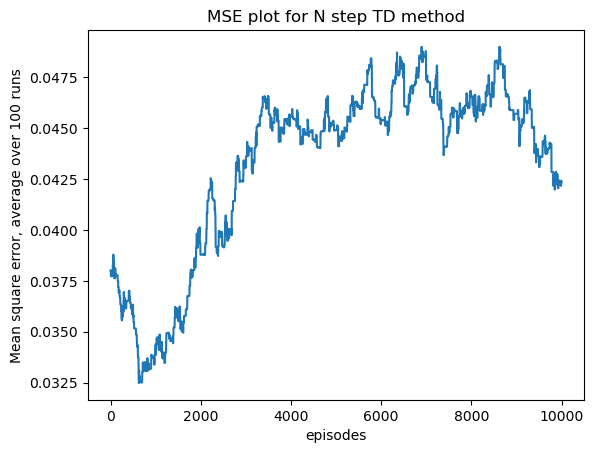

In [29]:
plt.plot(MSE_col_n_Step_TD)
plt.title("MSE plot for N step TD method")
plt.ylabel("Mean square error, average over 100 runs")
plt.xlabel("episodes")

The plot for MSE for n-Step TD method over 10000 iterations showed that MSE has some fluctuation, but the overall value is quite small compared to the case of n-Step SARSA method. When we view the tred of MSE, MSE generally decrease a little bit a first, then increase to iteration number around 400, then flutuated for iteration 4000 to 8000 and finally dropped after iteration 8000. For the case of n-Step Sarsa, the MSE curve never drop. Possible reason for this difference in trend of MSE plot and magnitude of MSE is that in n-Step TD, there is no factor $\rho$ what will possibly enlarge any errors made in calcutation.

Now we try to figure out a epsilon-greedy policy for playing blackjack by using our **n_Step TD control** METHOD.  
  
This is our implemented n_Step TD control algorithm findind an optimal policy playing Blakcjack. Mostly, the class below is borrowed from online article "Reinforcement Learning — Solving Blackjack" by Jeremy Zhang.
Except the part that we reare our own list of rewards and the final block of the code in this class "BlackJack_N_step_Sarsa_eval" that updates state value by N_step Sarsa method as in page 144 of textbook, "n-Step TD for estimating $V\approx v_\pi$".

In [30]:
class BlackJack_n_Step_TD_control(object):
    # init function borrowed from website article "Reinforcement Learning — Solving Blackjack"
    # by Jeremy Zhang in towardsdatascience.com
    # initizliation function of blackjack object
    def __init__(self,epsilon=0.1):
        #self.player_state_value = {}
        self.epsilon=epsilon
        self.lr = 0.1
        self.player_Q_Values={}
        self.policy = {} #initialize a epsilon-soft policy
        self.player_states = []
        self.player_final_rewards=[]
        self.player_draw = 0
        self.player_win=0


        # initialise V values | (12-21) x (1-10) x (True, False) x (1,0) 400 in total

        for i in range(12, 22):
            for j in range(1, 11):
                for k in [True, False]:
                    self.player_Q_Values[(i, j, k)] = {}
                    self.player_Q_Values[(i,j,k)][1]=0
                    self.player_Q_Values[(i,j,k)][0]=0
                    self.policy[(i,j,k)]=[0.5,0.5]
    # give card
    # give card function borrowed from website article "Reinforcement Learning — Solving Blackjack"
    # by Jeremy Zhang in towardsdatascience.com
    @staticmethod
    def giveCard():
        # 1 stands for ace
        c_list = list(range(1, 11)) + [10, 10, 10]
        return np.random.choice(c_list)
    # dealer policy and player policy function borrowed from website article
    # "Reinforcement Learning — Solving Blackjack"
    # by Jeremy Zhang in towardsdatascience.com
    def dealerPolicy(self, current_value, usable_ace, is_end):
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return current_value, usable_ace, True
        # HIT17
        if current_value >= 17:
            return current_value, usable_ace, True
        else:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value+11, True, False
                return current_value+1, usable_ace, False
            else:
                return current_value+card, usable_ace, False

    # one can only has 1 usable ace
    def playerPolicy(self, current_value, show_card, usable_ace, is_end):
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return current_value, usable_ace, None, True

        #always hit when total sum smaller than 12
        if current_value < 12:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value+11, True, 1, False
                return current_value+1, usable_ace, 1, False
            else:
                return current_value+card, usable_ace, 1, False
        # epsilon-soft policy here performed
        action = np.random.choice([0,1],p=self.policy[(current_value,show_card,usable_ace)])
        if action==0:
            return current_value, usable_ace, 0, True
        else:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value+11, True, 1, False
                return current_value+1, usable_ace, 1, False
            else:
                return current_value+card, usable_ace, 1, False


    # give credit function borrowed from website article
    # "Reinforcement Learning — Solving Blackjack"
    # by Jeremy Zhang in towardsdatascience.com
    def _giveCredit(self, player_value, dealer_value, cur_traj, is_end=True):
        if is_end:
            if player_value > 21:
                if dealer_value > 21:
                    # draw
                    self.player_draw += 1
                    self.player_final_rewards.append(0)
                else:
                    self.player_final_rewards.append(-1)
            else:
                if dealer_value > 21:
                    self.player_final_rewards.append(1)
                    self.player_win += 1
                else:
                    if player_value < dealer_value:
                        self.player_final_rewards.append(-1)
                    elif player_value > dealer_value:
                        self.player_final_rewards.append(1)
                        self.player_win += 1
                    else:
                        # draw
                        self.player_draw += 1
                        self.player_final_rewards.append(0)
    def play(self, rounds=1000,n=3):
        for i in range(rounds):
            if i % 10000 == 0:
                print("round", i)

            # hit 2 cards each
            dealer_value, player_value = 0, 0
            show_card = 0

            # give dealer 2 cards and show 1
            dealer_value += self.giveCard()
            show_card = dealer_value
            dealer_value += self.giveCard()

            #list of states for players
            lis_player_states = []

            #col of actions
            col_actions = {}
            # player's turn
            # always hit if less than 12
            usable_ace, is_end = False, False
            while True:

                player_value, usable_ace, action, is_end = self.playerPolicy(player_value, show_card, usable_ace, is_end)
                col_actions[(player_value, show_card, usable_ace)]=action

                # when value goes higher than 12, record states
                if (player_value >= 12) and (player_value <= 21):
                    lis_player_states.append((player_value, show_card, usable_ace))

                    #self.player_state_count[(player_value, show_card, usable_ace)]+=1

                if is_end:
                    break

            self.player_states.append(lis_player_states)
            # print("player card sum", player_value)

            # dealer's turn
            usable_ace, is_end = False, False
            while not is_end:
                dealer_value, usable_ace, is_end = self.dealerPolicy(dealer_value, usable_ace, is_end)

            # judge winner
            # set intermediate state to 0
            #for s in self.player_states:
            #    self.player_state_value[s] = 0 if self.player_state_value.get(s) is None else self.player_state_value.get(s)

            self._giveCredit(player_value, dealer_value,self.player_states[-1])

            #creating list of rewards
            rewards_here = list(np.zeros(len(self.player_states[i])-1))+[self.player_final_rewards[i]]

            #following code borrowed from my own solution in programming assignment 2
            #off policy n_step sarsa algorithm
            #help from class txt book, page 144, n step TD method estimating V approximately equivalent to v_pi
            t=0
            T=len(self.player_states[i])
            tau=0-n+1
            for t in range(0,T+n-1):
                tau=t-n+1
                if tau>=0:
                    upper = np.min([tau+n,T])
                    G=0
                    for ind in range(tau+1,upper+1):
                        G=G+rewards_here[ind-1]
                    if tau + n < T:
                        s_tau_n = self.player_states[i][tau + n]
                        a_tau_n = col_actions[s_tau_n]
                        G += self.player_Q_Values[s_tau_n][a_tau_n]
                    # Update the value for the state at time tau
                    s_tau = self.player_states[i][tau]
                    a_tau= col_actions[s_tau]




                    # Update value function value V(s_tau)
                    cur_val = self.player_Q_Values[s_tau][a_tau]
                    self.player_Q_Values[s_tau][a_tau]=cur_val+self.lr * (G - cur_val)
                    a_star = np.argmax([self.player_Q_Values[s_tau][0],self.player_Q_Values[s_tau][1]])

                    for a in range(2):
                        if a==a_star:
                            self.policy[s_tau][a]=1-self.epsilon+self.epsilon/2
                        else:
                            self.policy[s_tau][a]=self.epsilon/2





We develop an averaged policy for playing Blakcjack through using 5 seeds, and averaging the policy probabilities generated by the 5 seeds, 300 to 304.

In [31]:
policies_TD = []
for i in range(300,305):
    np.random.seed(i)
    b_N_TD_control = BlackJack_n_Step_TD_control()
    b_N_TD_control.play(rounds=10000)
    policies_TD.append(b_N_TD_control.policy)

round 0
round 0
round 0
round 0
round 0


In [32]:
final_policy_n_step_TD = {}
for i in range(12, 22):
    for j in range(1, 11):
        for k in [True, False]:
            final_policy_n_step_TD[(i,j,k)]=[0,0]
N=0
for ind in range(0,5):
    N=N+1
    for i in range(12, 22):
        for j in range(1, 11):
            for k in [True, False]:
                update_prob=policies_TD[ind][(i,j,k)]
                cur_prob=final_policy_n_step_TD[(i,j,k)]

                final_policy_n_step_TD[(i,j,k)][0]=cur_prob[0]+(1/N)*(update_prob[0]-cur_prob[0])
                final_policy_n_step_TD[(i,j,k)][1]=cur_prob[1]+(1/N)*(update_prob[1]-cur_prob[1])

In [33]:
final_policy_n_step_TD

{(12, 1, True): [0.5900000000000001, 0.41000000000000003],
 (12, 1, False): [0.05, 0.9500000000000001],
 (12, 2, True): [0.41, 0.5900000000000001],
 (12, 2, False): [0.41, 0.5900000000000001],
 (12, 3, True): [0.41, 0.5900000000000001],
 (12, 3, False): [0.05, 0.9500000000000001],
 (12, 4, True): [0.05, 0.9500000000000001],
 (12, 4, False): [0.05, 0.9500000000000001],
 (12, 5, True): [0.23000000000000004, 0.77],
 (12, 5, False): [0.05, 0.9500000000000001],
 (12, 6, True): [0.41, 0.5900000000000001],
 (12, 6, False): [0.41, 0.5900000000000001],
 (12, 7, True): [0.05, 0.9500000000000001],
 (12, 7, False): [0.22999999999999998, 0.7700000000000001],
 (12, 8, True): [0.05, 0.9500000000000001],
 (12, 8, False): [0.23, 0.7700000000000001],
 (12, 9, True): [0.14, 0.86],
 (12, 9, False): [0.05, 0.9500000000000001],
 (12, 10, True): [0.05, 0.9500000000000001],
 (12, 10, False): [0.22999999999999998, 0.7700000000000001],
 (13, 1, True): [0.23000000000000004, 0.77],
 (13, 1, False): [0.05, 0.95000

In [34]:
np.random.seed(500)
n_Step_TD_rerun=BlackJack_estimate_rerun(policy_prob=final_policy_n_step_TD)
n_Step_TD_rerun.play(10000)

Now we check the winning rate by policy chosen from n-Step TD method.

In [35]:
n_Step_TD_rerun.player_win,n_Step_TD_rerun.player_lose,n_Step_TD_rerun.player_draw

(3997, 4121, 1882)

In [36]:
print("n-Step TD winning rate: ",n_Step_TD_rerun.player_win/10000)

n-Step TD winning rate:  0.3997


Still, we did not beat the dealer. However, compared to off policy n-Step SARSA case, our winning rate increased from 37.4% to 39.97%.

## Section: Unweighted importance sampling Monte Carlo

First, we need to use following method to generate trajectories for Unweighted importance sampling Monte Carlo method.

This is our implemented unweighted Monte Carlo running algorithm generating trajcetories for further investigation. Mostly, the class below is borrowed from online article "Reinforcement Learning — Solving Blackjack" by Jeremy Zhang.  
Except the part that we add list of states in a single trajectory to our general list og trajectories "self.player_states". This part of code is inspired by our class test file from our class skeleton code for programming assignment 2.


In [37]:
class BlackJackMC_run(object):
    # init function borrowed from website article "Reinforcement Learning — Solving Blackjack"
    # by Jeremy Zhang in towardsdatascience.com
    # initizliation function of blackjack object
    def __init__(self):

        self.player_states = []
        self.player_final_rewards = []


        self.player_win = 0
        self.player_draw = 0




    # give card
    # give card function borrowed from website article "Reinforcement Learning — Solving Blackjack"
    # by Jeremy Zhang in towardsdatascience.com
    @staticmethod
    def giveCard():
        # 1 stands for ace
        c_list = list(range(1, 11)) + [10, 10, 10]
        return np.random.choice(c_list)
    # dealer policy and player policy function borrowed from website article
    # "Reinforcement Learning — Solving Blackjack"
    # by Jeremy Zhang in towardsdatascience.com
    def dealerPolicy(self, current_value, usable_ace, is_end):
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return current_value, usable_ace, True
        # HIT17
        if current_value >= 17:
            return current_value, usable_ace, True
        else:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value+11, True, False
                return current_value+1, usable_ace, False
            else:
                return current_value+card, usable_ace, False

    # one can only has 1 usable ace
    def playerPolicy(self, current_value, usable_ace, is_end):
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return current_value, usable_ace, True
        # HIT20
        if current_value >= 20:
            return current_value, usable_ace, True
        else:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value+11, True, False
                return current_value+1, usable_ace, False
            else:
                return current_value+card, usable_ace, False

    # give credit function borrowed from website article
    # "Reinforcement Learning — Solving Blackjack"
    # by Jeremy Zhang in towardsdatascience.com
    def _giveCredit(self, player_value, dealer_value, cur_traj, is_end=True):
        if is_end:
            # give reward only to last state
            # last_state = self.player_states[-1]
            if player_value > 21:
                if dealer_value > 21:
                    # draw
                    self.player_draw += 1
                    self.player_final_rewards.append(0)
                    #self.player_state_count[cur_traj[-1]] +=1
                else:
                    #self.player_state_value[last_state] -= 1
                    self.player_final_rewards.append(-1)
                    #self.player_V_Values[cur_traj[-1]] -=1
                    #self.player_state_count[cur_traj[-1]] +=1
            else:
                if dealer_value > 21:
                    # self.player_state_value[last_state] += 1
                    self.player_final_rewards.append(1)
                    #self.player_V_Values[cur_traj[-1]] +=1
                    #self.player_state_count[cur_traj[-1]] +=1
                    self.player_win += 1
                else:
                    if player_value < dealer_value:
                        #self.player_state_value[last_state] -= 1
                        self.player_final_rewards.append(-1)
                        #self.player_V_Values[cur_traj[-1]] -=1
                        #self.player_state_count[cur_traj[-1]] +=1
                    elif player_value > dealer_value:
                        #self.player_state_value[last_state] += 1
                        self.player_final_rewards.append(1)
                        #self.player_V_Values[cur_traj[-1]] +=1
                        #self.player_state_count[cur_traj[-1]] +=1
                        self.player_win += 1
                    else:
                        # draw
                        self.player_draw += 1
                        self.player_final_rewards.append(0)
                        #self.player_state_count[cur_traj[-1]] +=1


    def play(self, rounds=1000):
        for i in range(rounds):
            #if i % 10000 == 0:
            #    print("round", i)
            # hit 2 cards each
            dealer_value, player_value = 0, 0
            show_card = 0

            # give dealer 2 cards and show 1
            dealer_value += self.giveCard()
            show_card = dealer_value
            dealer_value += self.giveCard()

            #list of states for players
            lis_player_states = []

            # player's turn
            # always hit if less than 12
            usable_ace, is_end = False, False
            while True:
                player_value, usable_ace, is_end = self.playerPolicy(player_value, usable_ace, is_end)

                if is_end:
                    break
                # when value goes higher than 12, record states
                if (player_value >= 12) and (player_value <= 21):
                    lis_player_states.append((player_value, show_card, usable_ace))


            self.player_states.append(lis_player_states)
            # print("player card sum", player_value)

            # dealer's turn
            usable_ace, is_end = False, False
            while not is_end:
                dealer_value, usable_ace, is_end = self.dealerPolicy(dealer_value, usable_ace, is_end)
            # print("dealer card sum", dealer_value)

            # judge winner


            self._giveCredit(player_value, dealer_value,self.player_states[-1])


This is our implemented unweighted Monte Carlo **evaluation** algorithm generating trajcetories for further investigation. Mostly, the class below is borrowed from online article "Reinforcement Learning — Solving Blackjack" by Jeremy Zhang.  
Except the part that we create our own list of rewards and updating state value through Unweighted Monteh Carlo update, as given in page 109-110 of textbook, "Off-policy MC prediction (policy evaluation) for estimatin $Q\approx q_\pi$" in section 5.6 and page 104 of textbook, section 5.5, **equation 5.3, 5.4 and 5.5**.  


In [38]:
class BlackJackMC_eval(object):
    # init function borrowed from website article "Reinforcement Learning — Solving Blackjack"
    # by Jeremy Zhang in towardsdatascience.com
    # initizliation function of blackjack object
    def __init__(self,traj,chosen_state=(13,1,True)):
        #self.player_state_value = {}
        self.player_states = traj[0]
        self.player_final_rewards = traj[1]
        self.player_V_Values={}
        self.state_count={}
        self.chosen_state=chosen_state
        self.chosen_state_value = []


        # initialise V values | (12-21) x (1-10) x (True, False) 200 in total

        for i in range(12, 22):
            for j in range(1, 11):
                for k in [True, False]:
                    self.player_V_Values[(i, j, k)] = 0
                    #borrowed for my own programming assignment 2, method Monteo Carlo
                    self.state_count[(i, j, k)]= 0





    def play(self, rounds=1000):
        for i in range(rounds):
            #if i % 10000 == 0:
            #    print("round", i)


            #creating list of rewards
            rewards_here = list(np.zeros(len(self.player_states[i])-1))+[self.player_final_rewards[i]]

            #estimating state-action values
            #computing return
            G=0

            ratio=1
            #borrowed from my own programming assignment 2 code
            for j in range (len(self.player_states[i])-1,-1,-1):
                G=G+rewards_here[j]
                s_t = self.player_states[i][j]
                self.state_count[s_t] = self.state_count[s_t]+1
                ratio=ratio*2
                cur_val = self.player_V_Values[s_t]
                self.player_V_Values[s_t]=cur_val+(1/self.state_count[s_t])*(ratio*G-cur_val)

            self.chosen_state_value.append(self.player_V_Values[self.chosen_state])

taking 100 runs of our Unweighted Sampling Monte Carlo Method for estimating state values.
Each 10000 episodes.
Average result over the 100 runs to compute MSE errors at different episode.

In [39]:
state_eval = 0
chosen_state_val_lis = []
for ind in range(100):
    np.random.seed(ind)
    print(ind," seed: ",ind)
    b_run = BlackJackMC_run()
    b_run.play(10000)
    traj=[b_run.player_states,b_run.player_final_rewards]
    b_eval = BlackJackMC_eval(traj=traj)
    b_eval.play(10000)
    state_eval +=b_eval.player_V_Values[(13,1,True)]
    chosen_state_val_lis.append(b_eval.chosen_state_value)

0  seed:  0


1  seed:  1
2  seed:  2
3  seed:  3
4  seed:  4
5  seed:  5
6  seed:  6
7  seed:  7
8  seed:  8
9  seed:  9
10  seed:  10
11  seed:  11
12  seed:  12
13  seed:  13
14  seed:  14
15  seed:  15
16  seed:  16
17  seed:  17
18  seed:  18
19  seed:  19
20  seed:  20
21  seed:  21
22  seed:  22
23  seed:  23
24  seed:  24
25  seed:  25
26  seed:  26
27  seed:  27
28  seed:  28
29  seed:  29
30  seed:  30
31  seed:  31
32  seed:  32
33  seed:  33
34  seed:  34
35  seed:  35
36  seed:  36
37  seed:  37
38  seed:  38
39  seed:  39
40  seed:  40
41  seed:  41
42  seed:  42
43  seed:  43
44  seed:  44
45  seed:  45
46  seed:  46
47  seed:  47
48  seed:  48
49  seed:  49
50  seed:  50
51  seed:  51
52  seed:  52
53  seed:  53
54  seed:  54
55  seed:  55
56  seed:  56
57  seed:  57
58  seed:  58
59  seed:  59
60  seed:  60
61  seed:  61
62  seed:  62
63  seed:  63
64  seed:  64
65  seed:  65
66  seed:  66
67  seed:  67
68  seed:  68
69  seed:  69
70  seed:  70
71  seed:  71
72  seed:  72
73  seed: 

We check our unweighted sampling Monte Carlo method's performance on estimating state value for state player sum is 13, player has an usable ace and dealer shows an ace.

In [40]:
state_eval/100

-0.3119228288051818

In [41]:
basline_val

-0.19499478623566194

This is still not close from baseline value for state (13,1,True). However, the result is better compared to the case of off-policy n-Step Sarsa method's performace. For off-policy n-Step Sarsa method's case, the difference is between 0.048 and -0.19, about 0.24. In this unweighted sampling Monte Carlo Case, the difference is betwwen -0.31 and -0.19, about -0.12.     
We will have a further check of our unweighted sampling Monte Carlo method's performance on estimating state value for state player sum is 13, player has an usable ace and dealer shows an ace through computing an mean square error of our off_policy n-step Sarsa method's estimation of state value for state (13,1,True) throughout the 10000 iterations, and averaged over all 100 runs.

Computing mean square error averaging our unweighted sampling Monte Carlo method over 100 runs for each of episode.

In [42]:
MSE_UW_col = []

for iter in range(0,10000):
    MSE = 0
    N=0
    for j in range(0,100):
        N=N+1
        mse_cur = (chosen_state_val_lis[j][iter]-basline_val)**2
        MSE = MSE+(1/N)*(mse_cur-MSE)
    MSE_UW_col.append(MSE)

Text(0.5, 0, 'episodes')

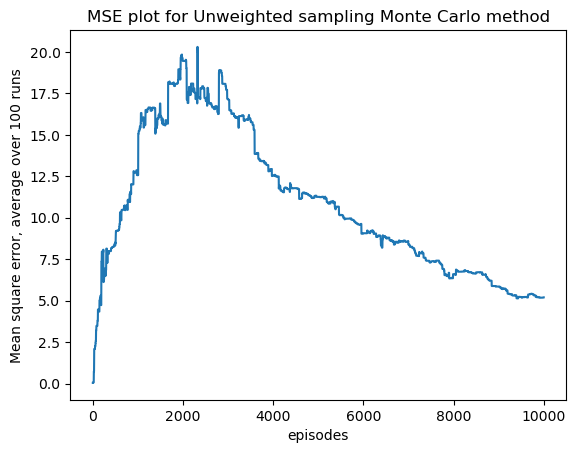

In [43]:
plt.plot(MSE_UW_col)
plt.title("MSE plot for Unweighted sampling Monte Carlo method")
plt.ylabel("Mean square error, average over 100 runs")
plt.xlabel("episodes")

The estimation error is generally far worse compared to the plot for n-step Sarsa, with MSE error staying below 0.225.  
  
However, the trend of MSE shown in plot for unweighted sampling Monte Carlo method is better, with a clear trend of decreasing MSE after around 3000 episodes.  

This is probably due to the fact that in our unweighted importance sampling Monte Carlo method, each state value is updated by only a ratio of 2 multiplying the return G, which means any error in our unweighted importance sampling Monte Carlo method enlarge and propagate at a smaller scale compared to that of off policy n-step Sarsa method.

Now we try to figure out a epsilon-greedy policy for playing blackjack by using our unweighted sampling Monte Carlo method.

This is our implemented unweighted Monte Carlo **control** algorithm finding a best policy of playing Blackjack. Mostly, the class below is borrowed from online article "Reinforcement Learning — Solving Blackjack" by Jeremy Zhang.  
Except the part that we create our own list of rewards and updating state value through Unweighted Monteh Carlo update, as given in page 109-110 of textbook, "Off-policy MC prediction (policy evaluation) for estimatin $Q\approx q_\pi$" in section 5.6 and page 104 of textbook, section 5.5, **equation 5.3, 5.4 and 5.5**.  
For the playerpolicy function below, the part of using a policy probability to choose action is inspired by programming assignment 1 skelenton code. The rest of parts are borrowed from online article "Reinforcement Learning — Solving Blackjack" by Jeremy Zhang.      


In [44]:
class BlackJackMC_control(object):
    # init function borrowed from website article "Reinforcement Learning — Solving Blackjack"
    # by Jeremy Zhang in towardsdatascience.com
    # initizliation function of blackjack object
    def __init__(self,epsilon=0.1):
        #self.player_state_value = {}
        self.epsilon=epsilon
        self.trajs = []
        self.player_Q_Values={}
        self.state_action_count={}
        self.policy = {} #initialize a epsilon-soft policy
        self.player_states = []
        self.player_final_rewards=[]
        self.player_draw = 0
        self.player_win=0


        # initialise V values | (12-21) x (1-10) x (True, False) x (1,0) 400 in total

        for i in range(12, 22):
            for j in range(1, 11):
                for k in [True, False]:
                    self.player_Q_Values[(i, j, k)] = {}
                    self.player_Q_Values[(i,j,k)][1]=0
                    self.player_Q_Values[(i,j,k)][0]=0
                    self.state_action_count[(i, j, k)]={}
                    self.state_action_count[(i, j, k)][1] = 0
                    self.state_action_count[(i, j, k)][0] = 0
                    self.policy[(i,j,k)]=[0.5,0.5]
    # give card
    # give card function borrowed from website article "Reinforcement Learning — Solving Blackjack"
    # by Jeremy Zhang in towardsdatascience.com
    @staticmethod
    def giveCard():
        # 1 stands for ace
        c_list = list(range(1, 11)) + [10, 10, 10]
        return np.random.choice(c_list)
    # dealer policy and player policy function borrowed from website article
    # "Reinforcement Learning — Solving Blackjack"
    # by Jeremy Zhang in towardsdatascience.com
    def dealerPolicy(self, current_value, usable_ace, is_end):
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return current_value, usable_ace, True
        # HIT17
        if current_value >= 17:
            return current_value, usable_ace, True
        else:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value+11, True, False
                return current_value+1, usable_ace, False
            else:
                return current_value+card, usable_ace, False

    # one can only has 1 usable ace
    def playerPolicy(self, current_value, show_card, usable_ace, is_end):
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return current_value, usable_ace, None, True

        #always hit when total sum smaller than 12
        if current_value < 12:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value+11, True, 1, False
                return current_value+1, usable_ace, 1, False
            else:
                return current_value+card, usable_ace, 1, False
        # epsilon-soft policy here performed
        action = np.random.choice([0,1],p=self.policy[(current_value,show_card,usable_ace)])
        if action==0:
            return current_value, usable_ace, 0, True
        else:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value+11, True, 1, False
                return current_value+1, usable_ace, 1, False
            else:
                return current_value+card, usable_ace, 1, False


    # give credit function borrowed from website article
    # "Reinforcement Learning — Solving Blackjack"
    # by Jeremy Zhang in towardsdatascience.com
    def _giveCredit(self, player_value, dealer_value, cur_traj, is_end=True):
        if is_end:
            if player_value > 21:
                if dealer_value > 21:
                    # draw
                    self.player_draw += 1
                    self.player_final_rewards.append(0)
                else:
                    self.player_final_rewards.append(-1)
            else:
                if dealer_value > 21:
                    self.player_final_rewards.append(1)
                    self.player_win += 1
                else:
                    if player_value < dealer_value:
                        self.player_final_rewards.append(-1)
                    elif player_value > dealer_value:
                        self.player_final_rewards.append(1)
                        self.player_win += 1
                    else:
                        # draw
                        self.player_draw += 1
                        self.player_final_rewards.append(0)
                        
    def play(self, rounds=1000):
        for i in range(rounds):
            if i % 10000 == 0:
                print("round", i)

            # hit 2 cards each
            dealer_value, player_value = 0, 0
            show_card = 0

            # give dealer 2 cards and show 1
            dealer_value += self.giveCard()
            show_card = dealer_value
            dealer_value += self.giveCard()

            #list of states for players
            lis_player_states = []

            #col of actions
            col_actions = {}
            # player's turn
            # always hit if less than 12
            usable_ace, is_end = False, False
            while True:

                player_value, usable_ace, action, is_end = self.playerPolicy(player_value, show_card, usable_ace, is_end)
                col_actions[(player_value, show_card, usable_ace)]=action

                # when value goes higher than 12, record states
                if (player_value >= 12) and (player_value <= 21):
                    lis_player_states.append((player_value, show_card, usable_ace))

                    #self.player_state_count[(player_value, show_card, usable_ace)]+=1

                if is_end:
                    break

            self.player_states.append(lis_player_states)
            # print("player card sum", player_value)

            # dealer's turn
            usable_ace, is_end = False, False
            while not is_end:
                dealer_value, usable_ace, is_end = self.dealerPolicy(dealer_value, usable_ace, is_end)

            # judge winner
            # set intermediate state to 0
            #for s in self.player_states:
            #    self.player_state_value[s] = 0 if self.player_state_value.get(s) is None else self.player_state_value.get(s)

            self._giveCredit(player_value, dealer_value,self.player_states[-1])

            #creating list of rewards
            rewards_here = list(np.zeros(len(self.player_states[i])-1))+[self.player_final_rewards[i]]


            #estimating state-action values
            G=0

            ratio=1
            #borrowed from my own programming assignment 2 code
            for j in range (len(self.player_states[i])-1,-1,-1):
                G=G+rewards_here[j]
                s_t = self.player_states[i][j]
                a_t= col_actions[s_t]
                self.state_action_count[s_t][a_t] = self.state_action_count[s_t][a_t]+1
                rt = self.policy[s_t][a_t] / 0.5
                ratio=ratio*rt
                cur_val = self.player_Q_Values[s_t][a_t]
                N = self.state_action_count[s_t][a_t]
                self.player_Q_Values[s_t][a_t]=cur_val+(1/N)*(ratio*G-cur_val)

                a_star = np.argmax([self.player_Q_Values[s_t][0],self.player_Q_Values[s_t][1]])

                for a in range(2):
                    if a==a_star:
                        self.policy[s_t][a]=1-self.epsilon+self.epsilon/2
                    else:
                        self.policy[s_t][a]=self.epsilon/2



We develop an averaged policy for playing Blakcjack through using 5 seeds, and averaging the policy probabilities generated by the 5 seeds, 300 to 304.

In [45]:
policies_UW_MonteCarlo = []
for i in range(300,305):
    np.random.seed(i)
    b_UWMC_control = BlackJackMC_control()
    b_UWMC_control.play(rounds=10000)
    policies_UW_MonteCarlo.append(b_UWMC_control.policy)

round 0
round 0
round 0
round 0
round 0


In [46]:
final_policy_UW_MonteCarlo = {}
for i in range(12, 22):
    for j in range(1, 11):
        for k in [True, False]:
            final_policy_UW_MonteCarlo[(i,j,k)]=[0,0]
N=0
for ind in range(0,5):
    N=N+1
    for i in range(12, 22):
        for j in range(1, 11):
            for k in [True, False]:
                update_prob=policies_UW_MonteCarlo[ind][(i,j,k)]
                cur_prob=final_policy_UW_MonteCarlo[(i,j,k)]

                final_policy_UW_MonteCarlo[(i,j,k)][0]=cur_prob[0]+(1/N)*(update_prob[0]-cur_prob[0])
                final_policy_UW_MonteCarlo[(i,j,k)][1]=cur_prob[1]+(1/N)*(update_prob[1]-cur_prob[1])

In [47]:
final_policy_UW_MonteCarlo

{(12, 1, True): [0.22999999999999998, 0.7700000000000001],
 (12, 1, False): [0.05, 0.9500000000000001],
 (12, 2, True): [0.5900000000000001, 0.41],
 (12, 2, False): [0.41, 0.5900000000000001],
 (12, 3, True): [0.41, 0.5900000000000001],
 (12, 3, False): [0.9500000000000001, 0.05],
 (12, 4, True): [0.41, 0.5900000000000001],
 (12, 4, False): [0.23, 0.7700000000000001],
 (12, 5, True): [0.5900000000000001, 0.41],
 (12, 5, False): [0.23000000000000004, 0.77],
 (12, 6, True): [0.41, 0.5900000000000001],
 (12, 6, False): [0.22999999999999998, 0.7700000000000001],
 (12, 7, True): [0.5900000000000001, 0.41000000000000003],
 (12, 7, False): [0.41, 0.5900000000000001],
 (12, 8, True): [0.5900000000000001, 0.41],
 (12, 8, False): [0.22999999999999998, 0.7700000000000001],
 (12, 9, True): [0.77, 0.23000000000000004],
 (12, 9, False): [0.22999999999999998, 0.7700000000000001],
 (12, 10, True): [0.41, 0.5900000000000001],
 (12, 10, False): [0.22999999999999998, 0.7700000000000001],
 (13, 1, True): 

In [48]:
np.random.seed(500)
UWMC_rerun=BlackJack_estimate_rerun(policy_prob=final_policy_UW_MonteCarlo)
UWMC_rerun.play(10000)
UWMC_rerun.player_win,UWMC_rerun.player_draw,UWMC_rerun.player_lose

(3927, 1691, 4382)

In [49]:
print("Unweighted sampling Monte Carlo winning rate: ",UWMC_rerun.player_win/10000)
print("Unweighted sampling Monte Carlo draw rate: ",UWMC_rerun.player_draw/10000)

Unweighted sampling Monte Carlo winning rate:  0.3927
Unweighted sampling Monte Carlo draw rate:  0.1691


Unfortunately we still fail to beat the dealer, however, we managed to have an improved winning rate from the original 1000000 runs with our fit policy and an improved winning rate over the case of off policy n_step Sarsa method.  
The improvement is from 30.6% to 37.4% by off policy n_step Sarsa method and finally to 39.27% by unweighted sampling Monte Carlo method.  
However, slightly lower than 39.97% by n-Step TD method.

## Section: Weighted Monte Carlo

This is our implemented Weighted Monte Carlo evaluation algorithm generating trajcetories for further investigation. Mostly, the class below is borrowed from online article "Reinforcement Learning — Solving Blackjack" by Jeremy Zhang.
Except the part that we create our own list of rewards and updating state value through Unweighted Monteh Carlo update, as given in page 109-110 of textbook, "Off-policy MC prediction (policy evaluation) for estimatin  $Q\approx q_\pi$ " in section 5.6 and page 104 of textbook, section 5.5, equation 5.3, 5.4 and 5.5.

In [50]:
class BlackJack_WMC_eval(object):
    # init function borrowed from website article "Reinforcement Learning — Solving Blackjack"
    # by Jeremy Zhang in towardsdatascience.com
    # initizliation function of blackjack object
    def __init__(self,traj,chosen_state=(13,1,True)):
        #self.player_state_value = {}
        self.player_states = traj[0]
        self.player_final_rewards = traj[1]
        self.player_V_Values={}
        self.state_count={}
        self.chosen_state=chosen_state
        self.chosen_state_value = []


        # initialise V values | (12-21) x (1-10) x (True, False) 200 in total

        for i in range(12, 22):
            for j in range(1, 11):
                for k in [True, False]:
                    self.player_V_Values[(i, j, k)] = 0
                    #borrowed for my own programming assignment 2, method Monteo Carlo
                    self.state_count[(i, j, k)]= 0





    def play(self, rounds=1000):
        for i in range(rounds):
            #if i % 10000 == 0:
            #    print("round", i)


            #creating list of rewards
            rewards_here = list(np.zeros(len(self.player_states[i])-1))+[self.player_final_rewards[i]]

            #estimating state-action values
            #computing return
            G=0

            W=1
            #borrowed from my own programming assignment 2 code
            for j in range (len(self.player_states[i])-1,-1,-1):
                G=G+rewards_here[j]
                s_t = self.player_states[i][j]
                self.state_count[s_t] = self.state_count[s_t]+W
                cur_val = self.player_V_Values[s_t]
                self.player_V_Values[s_t]=cur_val+(W/self.state_count[s_t])*(G-cur_val)
                W=W*2

            self.chosen_state_value.append(self.player_V_Values[self.chosen_state])

In [51]:
state_eval = 0
chosen_state_val_lis_02 = []
for ind in range(100):
    np.random.seed(ind)
    print(" seed: ",ind)
    b_run = BlackJackMC_run()
    b_run.play(10000)
    traj=[b_run.player_states,b_run.player_final_rewards]
    b_W_eval = BlackJack_WMC_eval(traj=traj)
    b_W_eval.play(10000)
    state_eval +=b_W_eval.player_V_Values[(13,1,True)]
    chosen_state_val_lis_02.append(b_W_eval.chosen_state_value)

 seed:  0


 seed:  1
 seed:  2
 seed:  3
 seed:  4
 seed:  5
 seed:  6
 seed:  7
 seed:  8
 seed:  9
 seed:  10
 seed:  11
 seed:  12
 seed:  13
 seed:  14
 seed:  15
 seed:  16
 seed:  17
 seed:  18
 seed:  19
 seed:  20
 seed:  21
 seed:  22
 seed:  23
 seed:  24
 seed:  25
 seed:  26
 seed:  27
 seed:  28
 seed:  29
 seed:  30
 seed:  31
 seed:  32
 seed:  33
 seed:  34
 seed:  35
 seed:  36
 seed:  37
 seed:  38
 seed:  39
 seed:  40
 seed:  41
 seed:  42
 seed:  43
 seed:  44
 seed:  45
 seed:  46
 seed:  47
 seed:  48
 seed:  49
 seed:  50
 seed:  51
 seed:  52
 seed:  53
 seed:  54
 seed:  55
 seed:  56
 seed:  57
 seed:  58
 seed:  59
 seed:  60
 seed:  61
 seed:  62
 seed:  63
 seed:  64
 seed:  65
 seed:  66
 seed:  67
 seed:  68
 seed:  69
 seed:  70
 seed:  71
 seed:  72
 seed:  73
 seed:  74
 seed:  75
 seed:  76
 seed:  77
 seed:  78
 seed:  79
 seed:  80
 seed:  81
 seed:  82
 seed:  83
 seed:  84
 seed:  85
 seed:  86
 seed:  87
 seed:  88
 seed:  89
 seed:  90
 seed:  91
 seed:  

We check our weighted sampling Monte Carlo method's performance on estimating state value for state player sum is 13, player has an usable ace and dealer shows an ace.

In [52]:
state_eval/100

-0.06859879474131947

In [53]:
basline_val

-0.19499478623566194

This is not close from baseline value for state (13,1,True), but the performance here is better compared to performance of off policy n-Step SARSA method, not as good as case of n-Step TD method. We will have a further check of our n-Step TD method's performance on estimating state value for state player sum is 13, player has an usable ace and dealer shows an ace through computing an mean square error of our off_policy n-step Sarsa method's estimation of state value for state (13,1,True) throughout the 10000 iterations, and averaged over all 100 runs.

Computing mean square error averaging our Weighted sampling Monte Carlo method over 100 runs for each of episode.

In [54]:
MSE_WMC_col = []

for iter in range(0,10000):
    MSE = 0
    N=0
    for j in range(0,100):
        N=N+1
        mse_cur = (chosen_state_val_lis_02[j][iter]-basline_val)**2
        MSE = MSE+(1/N)*(mse_cur-MSE)
    MSE_WMC_col.append(MSE)

Text(0.5, 0, 'episodes')

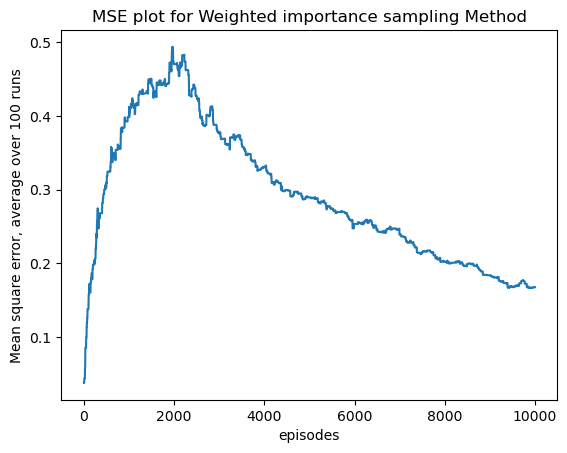

In [55]:
plt.plot(MSE_WMC_col)
plt.title("MSE plot for Weighted importance sampling Method")
plt.ylabel("Mean square error, average over 100 runs")
plt.xlabel("episodes")

The estimation error is generatlly far worse compared to the plot for n-step TD, with MSE error staying below 0.05. The trend are different that in plot above, MSE error decrease after iteration 2000 while in plot for n-Step TD, MSE error fluctuated but not decrease from iteration 4000 to 8000 and decrease after around iteration 8000.

The trend of MSE shown in plot for Weighted sampling Monte Carlo method is similar to the trend in plot for unweighted sampling Monte Carlo method, with a clear trend of decreasing MSE after around 2000 episodes.

Now we try to figure out a epsilon-greedy policy for playing blackjack by using our **Weighted sampling Monte Carlo method**.

This is our implemented weighted Monte Carlo control algorithm finding a best policy of playing Blackjack. Mostly, the class below is borrowed from online article "Reinforcement Learning — Solving Blackjack" by Jeremy Zhang.
Except the part that we create our own list of rewards and updating state value through Unweighted Monteh Carlo update, as given in page 109-110 of textbook, "Off-policy MC prediction (policy evaluation) for estimatin $Q\approx q_\pi$" in section 5.6 and page 104 of textbook, section 5.5, equation 5.3, 5.4 and 5.5.
For the playerpolicy function below, the part of using a policy probability to choose action is inspired by programming assignment 1 skelenton code. The rest of parts are borrowed from online article "Reinforcement Learning — Solving Blackjack" by Jeremy Zhang.

In [56]:
class BlackJack_WMC_control(object):
    # init function borrowed from website article "Reinforcement Learning — Solving Blackjack"
    # by Jeremy Zhang in towardsdatascience.com
    # initizliation function of blackjack object
    def __init__(self,epsilon=0.1):
        #self.player_state_value = {}
        self.epsilon=epsilon
        self.trajs = []
        self.player_Q_Values={}
        self.state_action_count={}
        self.policy = {} #initialize a epsilon-soft policy
        self.player_states = []
        self.player_final_rewards=[]
        self.player_draw = 0
        self.player_win=0


        # initialise V values | (12-21) x (1-10) x (True, False) x (1,0) 400 in total

        for i in range(12, 22):
            for j in range(1, 11):
                for k in [True, False]:
                    self.player_Q_Values[(i, j, k)] = {}
                    self.player_Q_Values[(i,j,k)][1]=0
                    self.player_Q_Values[(i,j,k)][0]=0
                    self.state_action_count[(i, j, k)]={}
                    self.state_action_count[(i, j, k)][1] = 0
                    self.state_action_count[(i, j, k)][0] = 0
                    self.policy[(i,j,k)]=[0.5,0.5]
    # give card
    # give card function borrowed from website article "Reinforcement Learning — Solving Blackjack"
    # by Jeremy Zhang in towardsdatascience.com
    @staticmethod
    def giveCard():
        # 1 stands for ace
        c_list = list(range(1, 11)) + [10, 10, 10]
        return np.random.choice(c_list)
    # dealer policy and player policy function borrowed from website article
    # "Reinforcement Learning — Solving Blackjack"
    # by Jeremy Zhang in towardsdatascience.com
    def dealerPolicy(self, current_value, usable_ace, is_end):
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return current_value, usable_ace, True
        # HIT17
        if current_value >= 17:
            return current_value, usable_ace, True
        else:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value+11, True, False
                return current_value+1, usable_ace, False
            else:
                return current_value+card, usable_ace, False

    # one can only has 1 usable ace
    def playerPolicy(self, current_value, show_card, usable_ace, is_end):
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return current_value, usable_ace, None, True

        #always hit when total sum smaller than 12
        if current_value < 12:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value+11, True, 1, False
                return current_value+1, usable_ace, 1, False
            else:
                return current_value+card, usable_ace, 1, False
        # epsilon-soft policy here performed
        action = np.random.choice([0,1],p=self.policy[(current_value,show_card,usable_ace)])
        if action==0:
            return current_value, usable_ace, 0, True
        else:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value+11, True, 1, False
                return current_value+1, usable_ace, 1, False
            else:
                return current_value+card, usable_ace, 1, False


    # give credit function borrowed from website article
    # "Reinforcement Learning — Solving Blackjack"
    # by Jeremy Zhang in towardsdatascience.com
    def _giveCredit(self, player_value, dealer_value, cur_traj, is_end=True):
        if is_end:
            if player_value > 21:
                if dealer_value > 21:
                    # draw
                    self.player_draw += 1
                    self.player_final_rewards.append(0)
                else:
                    self.player_final_rewards.append(-1)
            else:
                if dealer_value > 21:
                    self.player_final_rewards.append(1)
                    self.player_win += 1
                else:
                    if player_value < dealer_value:
                        self.player_final_rewards.append(-1)
                    elif player_value > dealer_value:
                        self.player_final_rewards.append(1)
                        self.player_win += 1
                    else:
                        # draw
                        self.player_draw += 1
                        self.player_final_rewards.append(0)
    def play(self, rounds=1000):
        for i in range(rounds):
            if i % 10000 == 0:
                print("round", i)

            # hit 2 cards each
            dealer_value, player_value = 0, 0
            show_card = 0

            # give dealer 2 cards and show 1
            dealer_value += self.giveCard()
            show_card = dealer_value
            dealer_value += self.giveCard()

            #list of states for players
            lis_player_states = []

            #col of actions
            col_actions = {}
            # player's turn
            # always hit if less than 12
            usable_ace, is_end = False, False
            while True:

                player_value, usable_ace, action, is_end = self.playerPolicy(player_value, show_card, usable_ace, is_end)
                col_actions[(player_value, show_card, usable_ace)]=action

                # when value goes higher than 12, record states
                if (player_value >= 12) and (player_value <= 21):
                    lis_player_states.append((player_value, show_card, usable_ace))

                    #self.player_state_count[(player_value, show_card, usable_ace)]+=1

                if is_end:
                    break

            self.player_states.append(lis_player_states)
            # print("player card sum", player_value)

            # dealer's turn
            usable_ace, is_end = False, False
            while not is_end:
                dealer_value, usable_ace, is_end = self.dealerPolicy(dealer_value, usable_ace, is_end)

            # judge winner
            # set intermediate state to 0
            #for s in self.player_states:
            #    self.player_state_value[s] = 0 if self.player_state_value.get(s) is None else self.player_state_value.get(s)

            self._giveCredit(player_value, dealer_value,self.player_states[-1])

            #creating list of rewards
            rewards_here = list(np.zeros(len(self.player_states[i])-1))+[self.player_final_rewards[i]]


            #estimating state-action values
            G=0

            W=1
            #borrowed from my own programming assignment 2 code
            for j in range (len(self.player_states[i])-1,-1,-1):
                G=G+rewards_here[j]
                s_t = self.player_states[i][j]
                a_t= col_actions[s_t]
                self.state_action_count[s_t][a_t] = self.state_action_count[s_t][a_t]+W

                cur_val = self.player_Q_Values[s_t][a_t]
                self.player_Q_Values[s_t][a_t]=cur_val+(W/self.state_action_count[s_t][a_t])*(G-cur_val)

                rt = self.policy[s_t][a_t] / 0.5
                W=W*rt
                a_star = np.argmax([self.player_Q_Values[s_t][0],self.player_Q_Values[s_t][1]])

                for a in range(2):
                    if a==a_star:
                        self.policy[s_t][a]=1-self.epsilon+self.epsilon/2
                    else:
                        self.policy[s_t][a]=self.epsilon/2



In [57]:
policies_WMC_MonteCarlo = []
for i in range(300,305):
    np.random.seed(i)
    b_WMC_control = BlackJack_WMC_control()
    b_WMC_control.play(rounds=10000)
    policies_WMC_MonteCarlo.append(b_WMC_control.policy)

round 0
round 0
round 0
round 0
round 0


In [58]:
final_policy_WMC_MonteCarlo = {}
for i in range(12, 22):
    for j in range(1, 11):
        for k in [True, False]:
            final_policy_WMC_MonteCarlo[(i,j,k)]=[0,0]
N=0
for ind in range(0,5):
    N=N+1
    for i in range(12, 22):
        for j in range(1, 11):
            for k in [True, False]:
                update_prob=policies_WMC_MonteCarlo[ind][(i,j,k)]
                cur_prob=final_policy_WMC_MonteCarlo[(i,j,k)]

                final_policy_WMC_MonteCarlo[(i,j,k)][0]=cur_prob[0]+(1/N)*(update_prob[0]-cur_prob[0])
                final_policy_WMC_MonteCarlo[(i,j,k)][1]=cur_prob[1]+(1/N)*(update_prob[1]-cur_prob[1])

In [59]:
final_policy_WMC_MonteCarlo

{(12, 1, True): [0.9500000000000001, 0.05],
 (12, 1, False): [0.05, 0.9500000000000001],
 (12, 2, True): [0.41, 0.5900000000000001],
 (12, 2, False): [0.22999999999999998, 0.7700000000000001],
 (12, 3, True): [0.5900000000000001, 0.41],
 (12, 3, False): [0.23, 0.7700000000000001],
 (12, 4, True): [0.41, 0.5900000000000001],
 (12, 4, False): [0.05, 0.9500000000000001],
 (12, 5, True): [0.41, 0.5900000000000001],
 (12, 5, False): [0.23000000000000004, 0.77],
 (12, 6, True): [0.7700000000000001, 0.22999999999999998],
 (12, 6, False): [0.05, 0.9500000000000001],
 (12, 7, True): [0.7700000000000001, 0.23],
 (12, 7, False): [0.23000000000000004, 0.77],
 (12, 8, True): [0.5900000000000001, 0.41],
 (12, 8, False): [0.23, 0.7700000000000001],
 (12, 9, True): [0.5900000000000001, 0.41],
 (12, 9, False): [0.22999999999999998, 0.7700000000000001],
 (12, 10, True): [0.41000000000000003, 0.5900000000000001],
 (12, 10, False): [0.05, 0.9500000000000001],
 (13, 1, True): [0.22999999999999998, 0.770000

Now we check winning rate of policy chosen by Weighted sampling Monte Carlo method playing Blackjack.

In [60]:
np.random.seed(500)
WMC_rerun=BlackJack_estimate_rerun(policy_prob=final_policy_WMC_MonteCarlo)
WMC_rerun.play(10000)
WMC_rerun.player_win,UWMC_rerun.player_draw,UWMC_rerun.player_lose

(3962, 1691, 4382)

In [61]:
print("Weighted MC Winning rate :",WMC_rerun.player_win/10000)

Weighted MC Winning rate : 0.3962


Winning rate 39.62%, this is close to 39.97% winning rate for n-Step TD and 39.27% winning rate for Unweighted sampling Monte Carlo.